### Understanding token embedding using bigram language model
This is based on Karpathy's implementation of the Bigram Model
- Bigram (one character predicts the next one with a lookup table of counts)
- Trying to understand how token embedding works
- Apparently, using a batch gradient descent, at seeded randomness, a lookup table gives virtually the same results. isn't this fascinating?


In [1]:
import random
with open("assets/names.txt", "r+") as f:
	words = f.read().splitlines()
	words = [word.strip() for word in words] # get rid of any trailing spaces
	words = [w for w in words if w] # get rid of any empty strings
	names = sorted(words, key=lambda x: random.random())
	
min_chars = 1
max_chars = max(len(v) for v in names)
chars = sorted(['.'] + list(set("".join(names))))

# in replacement of the start and end token. Every name should start and end with a period
chars_count = len(chars)
print("names: ", names[:5])
print("number of names: ", len(names))
print("(list of chars, count): ", ("".join(chars), chars_count))
print("(max word length, min word length): ", (max_chars, min_chars))

# adding start and end token to each name
# However using start and end token complicates the model
# names = [['<S>'] + list(name) + ['<E>'] for name in names]

names = [['.'] + list(name) + ['.'] for name in names]


names:  ['samay', 'fritz', 'courtlynn', 'maleyah', 'mikyle']
number of names:  32033
(list of chars, count):  ('.abcdefghijklmnopqrstuvwxyz', 27)
(max word length, min word length):  (15, 1)


In [2]:
b = {}
for name in names:
	for ch1, ch2 in zip(name, name[1:]):
		bigram = (ch1, ch2)
		b[bigram] = b.get(bigram, 0) + 1

b = sorted(b.items(), key = lambda kv: -kv[1])
print("max bigram occurance: ", b[0])
print("min bigram occurance: ", b[-1])
b = dict(b)

max bigram occurance:  (('n', '.'), 6763)
min bigram occurance:  (('k', 'f'), 1)


In [3]:
import torch

N = torch.zeros((chars_count, chars_count), dtype=torch.int32)

atoi = {ch:i for i,ch in enumerate(chars)}
itoa = {i:ch for i,ch in enumerate(chars)}

for name in names:
	for ch1, ch2 in zip(name, name[1:]):
		ix1, ix2 = atoi[ch1], atoi[ch2]
		N[ix1,ix2] += 1

N.size()


torch.Size([27, 27])

size:  torch.Size([27, 27])


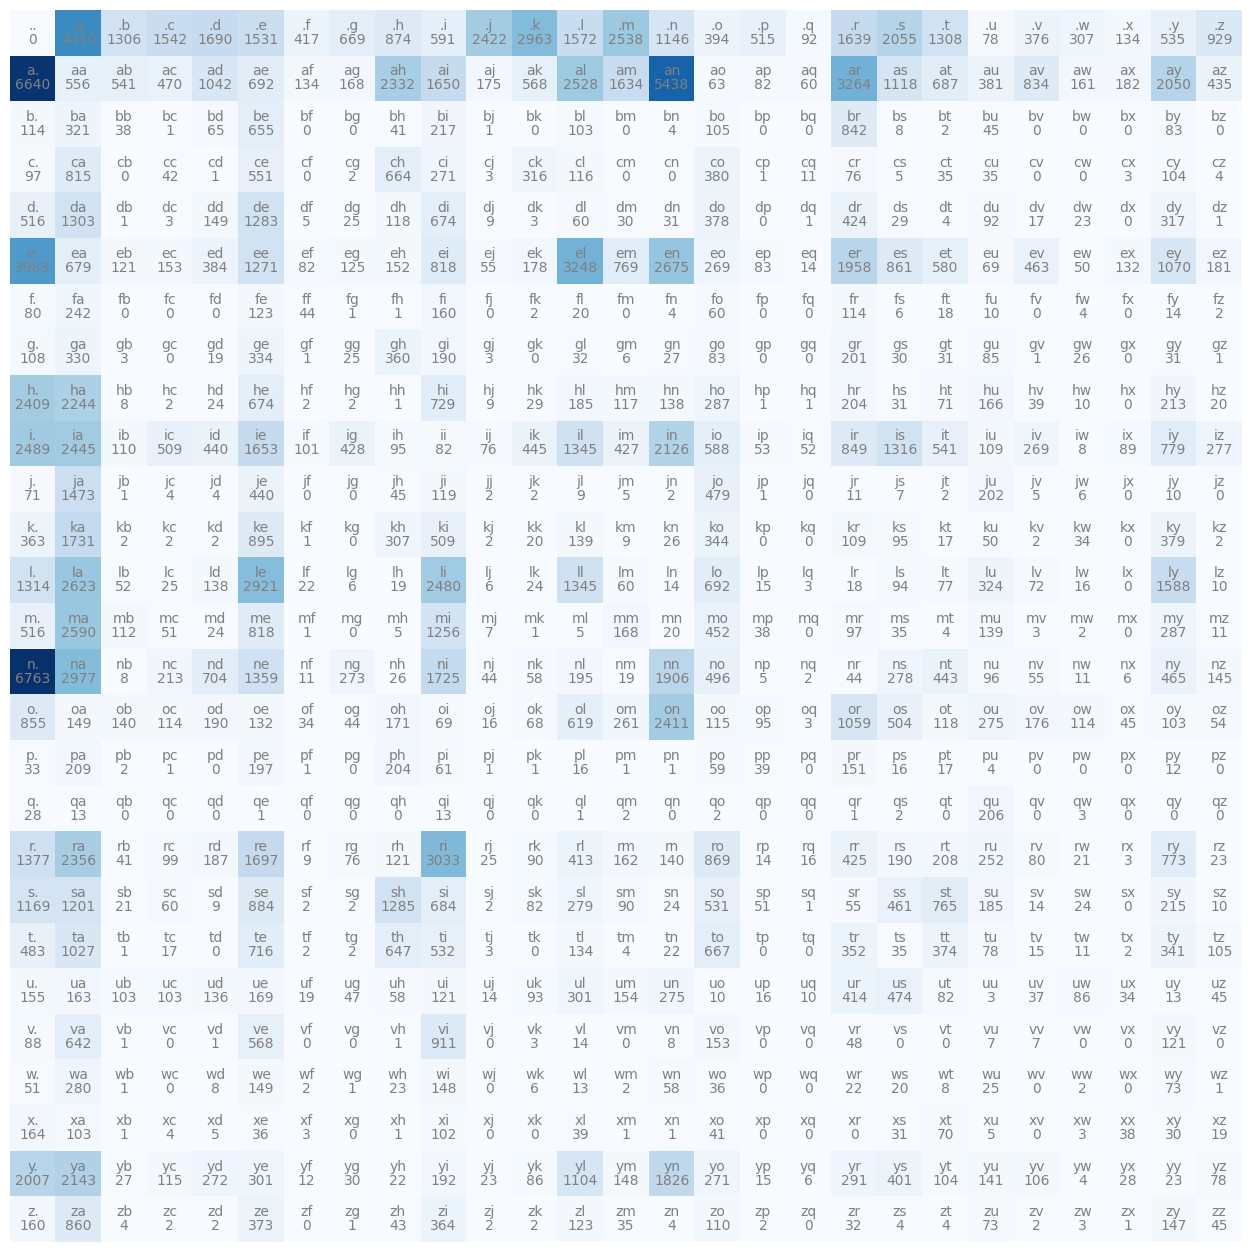

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
# visualization
def visualize(S, size=chars_count, dtype="int", skip=[]):
    plt.figure(figsize=(16,16))
    print("size: ", S.size())
    plt.imshow(S, cmap='Blues')

    for i in range(size):
        for j in range(size):
            chstr = itoa[i ] + itoa[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
            if dtype=="float":
                plt.text(j, i, f"{S[i,j].item():.3f}", ha="center", va="top", color='gray')
            else:
               plt.text(j, i, f"{S[i,j].item()}", ha="center", va="top", color='gray')

    
    plt.axis('off');

visualize(N)

In [5]:
# since <E> cannot begin a statement, and <S> can not end a statement.

# N_pop = torch.cat((N[:1], N[2:])) # pop second row
# N_pop = N_pop[:, 1:] # remove first column
# N_pop[:5], N_pop.size()

size:  torch.Size([27, 27])


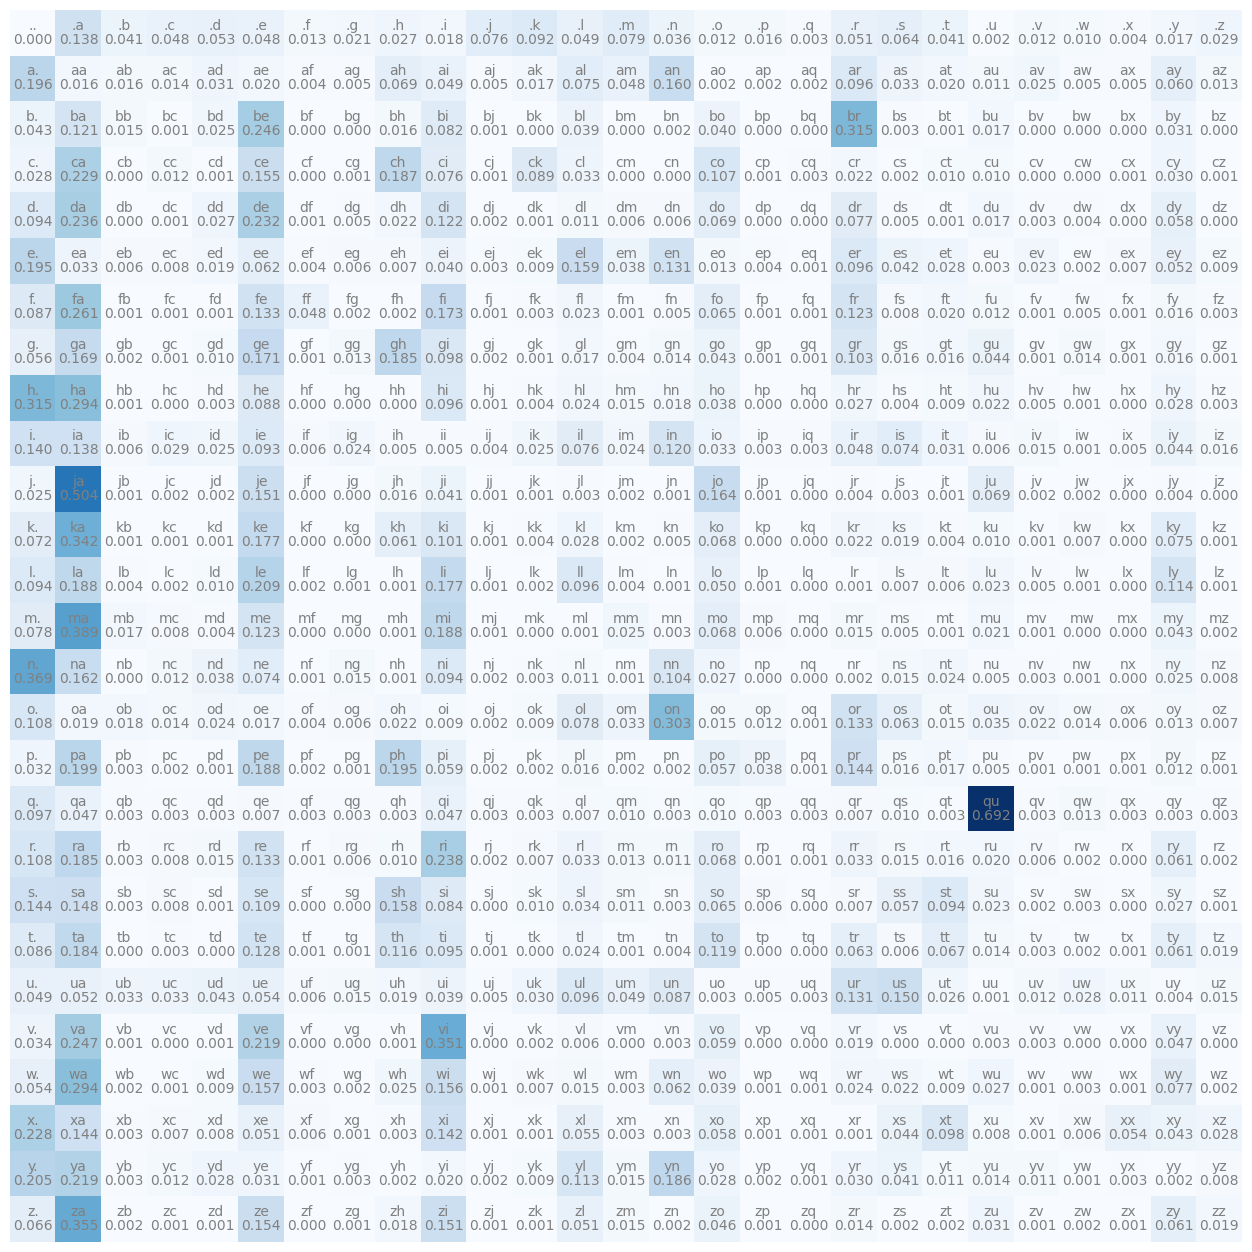

In [6]:
# Normalization of N

P = (N+1).float()
P /= P.sum(1, keepdims=True) # normalization along the horizontal

# normalization test
for i in range(27):
    assert P[i].sum() < 1.001 and P[i].sum() > 0.99, "print " + str(P[i].sum())

visualize(P, dtype="float")

In [7]:
# negative log likelihood
# formula = -log(P(x1,x2,x3...xn)) = -(log(P(x1)) + log(P(x2|x1)) + log(P(x3|x2)) + ... + log(P(xn|xn-1)))
@torch.no_grad()
def nnl(name):
  name = ['.'] + list(name) + ['.']
  n = 0
  log = torch.tensor(0, dtype=torch.float64)
  for ch1, ch2 in zip(name, name[1:]):
    ix1, ix2 = atoi[ch1], atoi[ch2]
    log += torch.log(P[ix1,ix2])
    n+=1
  log = -log
  return log/n

nnl("manan")

    

tensor(1.6597, dtype=torch.float64)

In [8]:
g = torch.Generator().manual_seed(2147483647)

print("generating...")
for i in range(15):
   out = []
   ix = 0
   while True:
      p = P[ix]
      ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
      out.append(itoa[ix])
      if ix == 0:
         break
   out.pop()

   word = ''.join(out)
   print("+ valid word: ", word, "\t\t\tnnl: ", nnl(word).item())
   


generating...
+ valid word:  junide 			nnl:  2.4060319321496144
+ valid word:  janasah 			nnl:  2.008928060531616
+ valid word:  p 			nnl:  3.781147837638855
+ valid word:  cony 			nnl:  2.344276189804077
+ valid word:  a 			nnl:  1.807007074356079
+ valid word:  nn 			nnl:  2.197669506072998
+ valid word:  kohin 			nnl:  2.395001928011576
+ valid word:  tolian 			nnl:  2.059293644768851
+ valid word:  juee 			nnl:  2.5174761056900024
+ valid word:  ksahnaauranilevias 			nnl:  2.6092579490260075
+ valid word:  dedainrwieta 			nnl:  2.957559924859267
+ valid word:  ssonielylarte 			nnl:  2.3059288603918895
+ valid word:  faveumerifontume 			nnl:  2.899183427586275
+ valid word:  phynslenaruani 			nnl:  2.624617258707682
+ valid word:  core 			nnl:  2.1869146108627318


In [9]:
import time
g = torch.Generator().manual_seed(2147483647)

generated_names = []
print("generating...")
start_time = time.time()
while True:
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoa[ix])
        if ix == 0:
            break
    out.pop()
    word = ''.join(out)
    # streamlining results
    if nnl(word) < 1.7 and len(word) > 3 and word not in generated_names:
        print("+ valid word: ", word)
        generated_names.append(word) 
    if len(generated_names) == 10:
        break
# generated_names
duration = time.time() - start_time
print("duration: ", duration)
with open(".generated.txt", "w") as f: 
	joined = "\n".join(generated_names)
	f.write(joined)


    

generating...
+ valid word:  jann
+ valid word:  anan
+ valid word:  jaman
+ valid word:  jahan
+ valid word:  janan
+ valid word:  jaran
+ valid word:  kanan
+ valid word:  manan
+ valid word:  kahan
+ valid word:  jarin
duration:  14.985629796981812


In [10]:
n = 0
nnls = torch.tensor(0, dtype=torch.float64)
for name in names:
    name = name[1:-1]
    x = nnl(name)
    nnls += x
    n+=1
print("cross entropy loss is", (nnls/n).item())
    

cross entropy loss is 2.4605745556427774


### NN
- Using neural network to arrive at the same result

In [11]:
# create the training set of bigrams (x,y)
train, val = [], []

for name in names:
  for ch1, ch2 in zip(name, name[1:]):
    ix1 = atoi[ch1]
    ix2 = atoi[ch2]
    train.append(ix1)
    val.append(ix2)
# train = train[:5]
# val = val[:5]
train = torch.tensor(train)
val = torch.tensor(val)
val, train

(tensor([19,  1, 13,  ...,  5, 24,  0]),
 tensor([ 0, 19,  1,  ...,  4,  5, 24]))

In [12]:
import torch.nn.functional as F
xenc = F.one_hot(train, num_classes=27).float()

# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

logits =  xenc @ W # log-counts

# applying softmax
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdim=True) 

In [13]:
# measuring the mean negative log likelihood
n = len(train)
for i in range(10):
    x = train[i].item() # input character index
    y = val[i].item() # label character index
    print(f"for {itoa[x]}, the answer is {itoa[y]}, with prob: {probs[i][y]:.3f}", )
    

for ., the answer is s, with prob: 0.005
for s, the answer is a, with prob: 0.012
for a, the answer is m, with prob: 0.011
for m, the answer is a, with prob: 0.074
for a, the answer is y, with prob: 0.050
for y, the answer is ., with prob: 0.030
for ., the answer is f, with prob: 0.003
for f, the answer is r, with prob: 0.057
for r, the answer is i, with prob: 0.092
for i, the answer is t, with prob: 0.031


In [14]:
loss = -probs[torch.arange(n), val].log().mean()
print("cross entropy loss is", loss.item())

cross entropy loss is 3.758953809738159


In [15]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

# gradient descent
while True:

    if loss < 2.49:
        break
    # forward pass
    xenc = F.one_hot(train, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(n), val].log().mean() + 0.01*(W**2).mean()
    print(loss.item())

  
  # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()
  
  # update
    W.data += -50 * W.grad

3.7686190605163574
3.3788065910339355
3.16109037399292
3.0271859169006348
2.9344842433929443
2.8672313690185547
2.816654682159424
2.777146339416504
2.7452542781829834
2.7188308238983154
2.696505308151245
2.6773719787597656
2.6608052253723145
2.6463513374328613
2.633665084838867
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794439315796
2.5886809825897217
2.5822560787200928
2.576429843902588
2.5711236000061035
2.566272735595703
2.5618226528167725
2.5577263832092285
2.5539441108703613
2.550442695617676
2.5471925735473633
2.5441696643829346
2.5413525104522705
2.538722038269043
2.536262035369873
2.5339581966400146
2.531797409057617
2.5297679901123047
2.527859926223755
2.526063919067383
2.5243704319000244
2.522773265838623
2.521263837814331
2.519836664199829
2.5184857845306396
2.5172054767608643
2.515990734100342
2.5148372650146484
2.5137407779693604
2.512697696685791
2.511704444885254
2.5107579231262207
2.509854793548584
2.5089924335479736
2.5081682205200195
2.50738024711608

In [16]:
# GENERATE FROM THE 'NEURAL NET' MODEL
g = torch.Generator().manual_seed(2147483647)

for i in range(15):
  
  out = []
  ix = 0
  while True:
    
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itoa[ix])
    if ix == 0:
      break
  print("+ valid word: ", ''.join(out), "\t\t\tnnl: ", nnl(out).item())

+ valid word:  junide. 			nnl:  3.402198478579521
+ valid word:  janasah. 			nnl:  2.9385320875379772
+ valid word:  p. 			nnl:  5.979219992955525
+ valid word:  cfay. 			nnl:  4.553623616695404
+ valid word:  a. 			nnl:  4.663126150767009
+ valid word:  nn. 			nnl:  4.242093205451965
+ valid word:  kohin. 			nnl:  3.535053695951189
+ valid word:  tolian. 			nnl:  3.098802477121353
+ valid word:  juwe. 			nnl:  3.7845609188079834
+ valid word:  kalanaauranilevias. 			nnl:  2.728117847442627
+ valid word:  dedainrwieta. 			nnl:  3.487403094768524
+ valid word:  ssonielylarte. 			nnl:  2.843891223271688
+ valid word:  faveumerifontume. 			nnl:  3.314526809586419
+ valid word:  phynslenaruani. 			nnl:  3.1090389490127563
+ valid word:  core. 			nnl:  3.5516562263170877


In [17]:
g = torch.Generator().manual_seed(2147483647)

generated_names = []
print("generating...")
start_time = time.time()
while True:
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # ----------
    
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoa[ix])
        if ix == 0:
            break
    out.pop()
    word = ''.join(out)
    # streamlining results
    if nnl(word) < 1.7 and len(word) > 3 and word not in generated_names:
        print("+ valid word: ", word)
        generated_names.append(word) 
    if len(generated_names) == 10:
        break
duration = time.time() - start_time
print("duration: ", duration)

generating...
+ valid word:  jann
+ valid word:  anan
+ valid word:  jaman
+ valid word:  jahan
+ valid word:  janan
+ valid word:  jaran
+ valid word:  kanan
+ valid word:  manan
+ valid word:  kahan
+ valid word:  jarin
duration:  37.97137451171875
